In [1]:
import sys
sys.path.append("models/vector")

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch_geometric.transforms as transforms
from torch_geometric.loader import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from auxiliary.visualization import visualize_losses, visualize_confusion_matrix
from auxiliary.misc import send_notification, get_model_name

from initialize_gnn import initialize_gnn
from dataset_vector import BuildingVectorDataset

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, then MPS, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    vector_path = "../scratch/vector"
else:
    device = torch.device("cpu")
    # local path
    vector_path = "../data.nosync/vector"

print(f"Device set to: {device}")

Device set to: cpu


In [4]:
# operators are always specified in this order
operator_order = ("elimination", "aggregation", "typification", "displacement", "enlargement", "simplification")

In [5]:
# features are always specified in this order
feature_order = ("area", 
                 "perimeter", 
                 "convexity", 
                 "eri", 
                 "orientation_mbr", 
                 "wall_average", 
                 "voronoi_area", 
                 "impact_area", 
                 "x_coord", 
                 "y_coord")

In [6]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

## Elimination model

In [7]:
# define path to training and validation data
path_to_training_data = os.path.join(vector_path, "training_data", "elimination", "training")
path_to_validation_data = os.path.join(vector_path, "training_data", "elimination", "validation")
path_to_test_data = os.path.join(vector_path, "training_data", "elimination", "test")

# define input parameters
elimination_operators = ["elimination"]
features = ["area", "perimeter", "convexity", "eri", "orientation_mbr", "wall_average", "voronoi_area", "impact_area", "x_coord", "y_coord"]
attach_roads = True

# batch size for DataLoaders
batch_size = 16

# construct training DataLoader
training_set = BuildingVectorDataset(path_to_training_data, 
                                     operators=elimination_operators, 
                                     operator_order=operator_order,
                                     features=features,
                                     feature_order=feature_order,
                                     attach_roads=attach_roads, 
                                     transform=None,
                                     subset=1000)
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)

# construct validation DataLoader (no transformations, no shuffling)
validation_set = BuildingVectorDataset(path_to_validation_data, 
                                       operators=elimination_operators, 
                                       operator_order=operator_order,
                                       features=features,
                                       feature_order=feature_order,
                                       attach_roads=attach_roads, 
                                       transform=None,
                                       subset=1000)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

# construct test DataLoader (no transformations, no shuffling)
test_set = BuildingVectorDataset(path_to_test_data, 
                                 operators=elimination_operators, 
                                 operator_order=operator_order,
                                 features=features,
                                 feature_order=feature_order,
                                 attach_roads=attach_roads, 
                                 transform=None,
                                 subset=1000)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

1,000 samples in the training set.
1,000 samples in the validation set.
1,000 samples in the test set.


In [9]:
#model = initialize_gnn(model="hgnn", sample=training_set.get(2), hidden_channels=128, num_layers=2, node_to_predict="focal_building")
model = initialize_gnn(model="hgt", sample=training_set.get(2), hidden_channels=128, num_heads=2, 
                        num_layers=2, node_to_predict="focal_building")

model.to(device)

learning_rate = 0.0005
criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"Using {model}")

Number of node features: {'focal_building': 10, 'context_building': 10, 'road': 2}, 1 operators
Using HGT with 645,539 parameters


### Training loop

In [10]:
# number of epochs
n_epochs = 10

total_samples = len(training_set)
n_iterations = math.ceil(total_samples/batch_size)
    
# saving the losses from every epoch
training_losses = []
validation_losses = []

start_time = time.perf_counter()
    
for epoch in range(n_epochs):
    # tracking loss per epoch
    training_running_loss = 0.0
    n_training_batches = 0
    validation_running_loss = 0.0
    n_validation_batches = 0

    # training phase
    model.train()

    for i, graph in enumerate(training_loader):
        n_training_batches += 1

        # operators applied to the focal building
        operators = graph.y
        
        # moving the features to device
        graph = graph.to(device)
        operators = operators.to(device)
    
        # empty the gradients
        optimizer.zero_grad()
            
        # forward pass
        pred_operators_logits = model(graph.x_dict, graph.edge_index_dict) # compute predictions, calls forward method under the hood
        loss = criterion(pred_operators_logits, operators) # calculate loss
        training_running_loss += loss.item() # tracking running loss to keep track of the loss for every epoch
    
        # backward pass
        loss.backward() # backpropagation
        optimizer.step() # update the parameters
    
        # print information every few batches
        if not (i + 1) % (n_iterations // 10):
            print(f"epoch {epoch+1}/{n_epochs}, step {i+1}/{n_iterations}")

    # validation phase
    model.eval()

    with torch.no_grad():
        for graph in validation_loader:
            n_validation_batches += 1
            # operators applied to the focal building
            operators = graph.y
            
            # moving the features to device
            graph = graph.to(device)
            operators = operators.to(device)

            # prediction on the trained model results in logits
            pred_operators_logits = model(graph.x_dict, graph.edge_index_dict) # compute predictions, calls forward method under the hood
            # calculate and store validation loss
            loss = criterion(pred_operators_logits, operators)
            validation_running_loss += loss.item()
    
    # print information at the end of each epoch
    training_loss_epoch = training_running_loss / n_training_batches
    training_losses.append(training_loss_epoch)
    validation_loss_epoch = validation_running_loss / n_validation_batches
    validation_losses.append(validation_loss_epoch)
    
    print(f"epoch {epoch+1} finished, training loss: {training_loss_epoch:.3f}, validation loss: {validation_loss_epoch:.3f}")

end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:,.3f} seconds")

# saving the losses
model_name = get_model_name(model, ops="eli", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
losses_path = os.path.join(vector_path, "model_outputs", "elimination", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=end_time-start_time)

epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.693, validation loss: 0.693
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.694, validation loss: 0.692
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.680, validation loss: 0.662
epoch 4/10, step 6/63
epoch 4/10, step 12/63
epoch 4/10, step 18/63
epoch 4/10, step 24/63
epoch 4/10, step 30/63
epoch 4/10

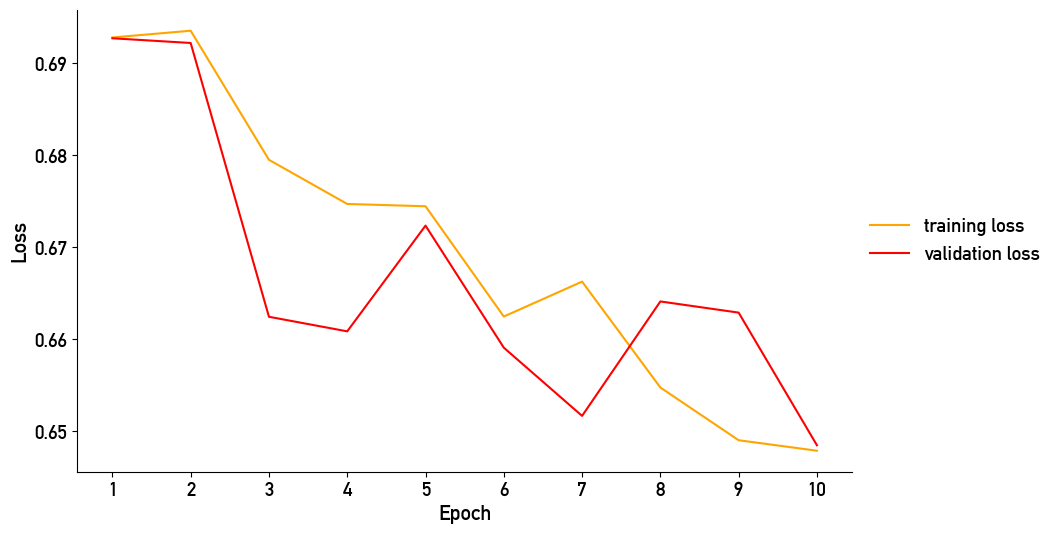

In [11]:
loss_path = os.path.join(vector_path, "model_outputs", "elimination", "losses")
visualize_losses([model_name], loss_path)

### Accuracy metrics after training

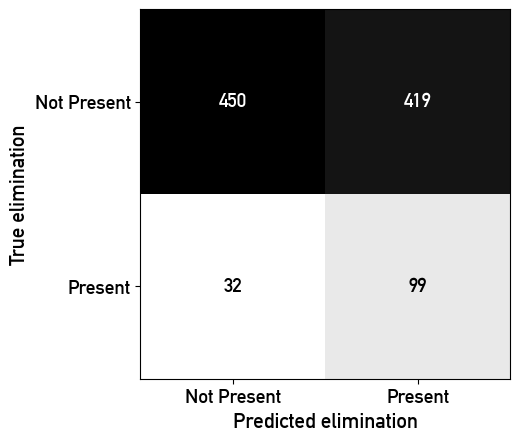

Accuracy: 0.549
Precision: 0.191
Recall: 0.756
F1 Score: 0.305


In [12]:
# switch to evaluation mode
model.eval()

# storing the predictions and true labels from every batch
true_elimination = []
pred_elimination = []

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for graph in test_loader:
        # operators applied to the focal building
        operators = graph.y
        
        # moving the features to device
        graph = graph.to(device)
        operators = operators.to(device)

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators_logits = model(graph.x_dict, graph.edge_index_dict)
        pred_operators = torch.sigmoid(pred_operators_logits)
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding
        
        # extracting true and predicted elimination
        true_elimination_batch = operators[:,0]
        pred_elimination_batch = pred_operators_labels[:,0]

        # collect data for metrics calculation
        true_elimination.append(true_elimination_batch.cpu())
        pred_elimination.append(pred_elimination_batch.cpu())

# convert lists to tensors
true_elimination = torch.cat(true_elimination)
pred_elimination = torch.cat(pred_elimination)

# calculate metrics
conf_matrix = confusion_matrix(true_elimination.numpy(), pred_elimination.numpy())
accuracy = accuracy_score(true_elimination.numpy(), pred_elimination.numpy())
precision = precision_score(true_elimination.numpy(), pred_elimination.numpy())
recall = recall_score(true_elimination.numpy(), pred_elimination.numpy())
f1 = f1_score(true_elimination.numpy(), pred_elimination.numpy())

# saving the accuracy metrics
model_name = get_model_name(model, ops="eli", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
metrics_path = os.path.join(vector_path, "model_outputs", "elimination", "metrics", model_name)

# creating a DataFrame with loss values
metrics_df = pd.DataFrame({"operator": ["elimination"],
                           "accuracy": [accuracy], 
                           "precision": [precision],
                           "recall": [recall],
                           "f1-score": [f1]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# display the confusion matrix
visualize_confusion_matrix(conf_matrix, operator="elimination")

# print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

### Saving the model

In [13]:
# save the trained model to disk
path_to_models = os.path.join(vector_path, "models", "elimination")

model_name = get_model_name(model, ops="eli", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))

## Selection model

In [14]:
# define path to training and validation data
path_to_training_data = os.path.join(vector_path, "training_data", "selection", "training")
path_to_validation_data = os.path.join(vector_path, "training_data", "selection", "validation")
path_to_test_data = os.path.join(vector_path, "training_data", "selection", "test")

# define input parameters
selection_operators = ["aggregation", "typification", "displacement", "enlargement"]
features = ["area", "perimeter", "convexity", "eri", "orientation_mbr", "wall_average", "voronoi_area", "impact_area", "x_coord", "y_coord"]
attach_roads = True

# batch size for DataLoaders
batch_size = 16

# construct training DataLoader
training_set = BuildingVectorDataset(path_to_training_data, 
                                     operators=selection_operators, 
                                     operator_order=operator_order,
                                     features=features,
                                     feature_order=feature_order,
                                     attach_roads=attach_roads, 
                                     transform=None,
                                     subset=1000)
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)

# construct validation DataLoader (no transformations, no shuffling)
validation_set = BuildingVectorDataset(path_to_validation_data, 
                                       operators=selection_operators, 
                                       operator_order=operator_order,
                                       features=features,
                                       feature_order=feature_order,
                                       attach_roads=attach_roads, 
                                       transform=None,
                                       subset=1000)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

# construct test DataLoader (no transformations, no shuffling)
test_set = BuildingVectorDataset(path_to_test_data, 
                                 operators=selection_operators, 
                                 operator_order=operator_order,
                                 features=features,
                                 feature_order=feature_order,
                                 attach_roads=attach_roads, 
                                 transform=None,
                                 subset=1000)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

1,000 samples in the training set.
1,000 samples in the validation set.
1,000 samples in the test set.


In [15]:
#model = initialize_gnn(model="hgnn", sample=training_set.get(2), hidden_channels=128, num_layers=2, node_to_predict="focal_building")
model = initialize_gnn(model="hgt", sample=training_set.get(2), hidden_channels=128, num_heads=2, 
                        num_layers=2, node_to_predict="focal_building")

model.to(device)

learning_rate = 0.0005
criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"Using {model}")

Number of node features: {'focal_building': 10, 'context_building': 10, 'road': 2}, 4 operators
Using HGT with 695,462 parameters


### Training loop

In [16]:
# number of epochs
n_epochs = 10

total_samples = len(training_set)
n_iterations = math.ceil(total_samples/batch_size)
    
# saving the losses from every epoch
training_losses = []
validation_losses = []

start_time = time.perf_counter()
    
for epoch in range(n_epochs):
    # tracking loss per epoch
    training_running_loss = 0.0
    n_training_batches = 0
    validation_running_loss = 0.0
    n_validation_batches = 0

    # training phase
    model.train()

    for i, graph in enumerate(training_loader):
        n_training_batches += 1
        # operators applied to the focal building
        operators = graph.y
        
        # moving the features to device
        graph = graph.to(device)
        operators = operators.to(device)
    
        # empty the gradients
        optimizer.zero_grad()
            
        # forward pass
        pred_operators_logits = model(graph.x_dict, graph.edge_index_dict) # compute predictions, calls forward method under the hood
        loss = criterion(pred_operators_logits, operators) # calculate loss
        training_running_loss += loss.item() # tracking running loss to keep track of the loss for every epoch
    
        # backward pass
        loss.backward() # backpropagation
        optimizer.step() # update the parameters
    
        # print information every few batches
        if not (i + 1) % (n_iterations // 10):
            print(f"epoch {epoch+1}/{n_epochs}, step {i+1}/{n_iterations}")

    # validation phase
    model.eval()

    with torch.no_grad():
        for graph in validation_loader:
            n_validation_batches += 1
            # operators applied to the focal building
            operators = graph.y
            
            # moving the features to device
            graph = graph.to(device)
            operators = operators.to(device)

            # prediction on the trained model results in logits
            pred_operators_logits = model(graph.x_dict, graph.edge_index_dict) # compute predictions, calls forward method under the hood
            # calculate and store validation loss
            loss = criterion(pred_operators_logits, operators)
            validation_running_loss += loss.item()
    
    # print information at the end of each epoch
    training_loss_epoch = training_running_loss / n_training_batches
    training_losses.append(training_loss_epoch)
    validation_loss_epoch = validation_running_loss / n_validation_batches
    validation_losses.append(validation_loss_epoch)
    
    print(f"epoch {epoch+1} finished, training loss: {training_loss_epoch:.3f}, validation loss: {validation_loss_epoch:.3f}")

end_time = time.perf_counter()
print(f"Training time: {end_time - start_time:,.3f} seconds")

# saving the losses
model_name = get_model_name(model, ops="sel", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
losses_path = os.path.join(vector_path, "model_outputs", "selection", "losses", model_name)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=end_time-start_time)

epoch 1/10, step 6/63
epoch 1/10, step 12/63
epoch 1/10, step 18/63
epoch 1/10, step 24/63
epoch 1/10, step 30/63
epoch 1/10, step 36/63
epoch 1/10, step 42/63
epoch 1/10, step 48/63
epoch 1/10, step 54/63
epoch 1/10, step 60/63
epoch 1 finished, training loss: 0.688, validation loss: 0.683
epoch 2/10, step 6/63
epoch 2/10, step 12/63
epoch 2/10, step 18/63
epoch 2/10, step 24/63
epoch 2/10, step 30/63
epoch 2/10, step 36/63
epoch 2/10, step 42/63
epoch 2/10, step 48/63
epoch 2/10, step 54/63
epoch 2/10, step 60/63
epoch 2 finished, training loss: 0.682, validation loss: 0.677
epoch 3/10, step 6/63
epoch 3/10, step 12/63
epoch 3/10, step 18/63
epoch 3/10, step 24/63
epoch 3/10, step 30/63
epoch 3/10, step 36/63
epoch 3/10, step 42/63
epoch 3/10, step 48/63
epoch 3/10, step 54/63
epoch 3/10, step 60/63
epoch 3 finished, training loss: 0.649, validation loss: 0.622
epoch 4/10, step 6/63
epoch 4/10, step 12/63
epoch 4/10, step 18/63
epoch 4/10, step 24/63
epoch 4/10, step 30/63
epoch 4/10

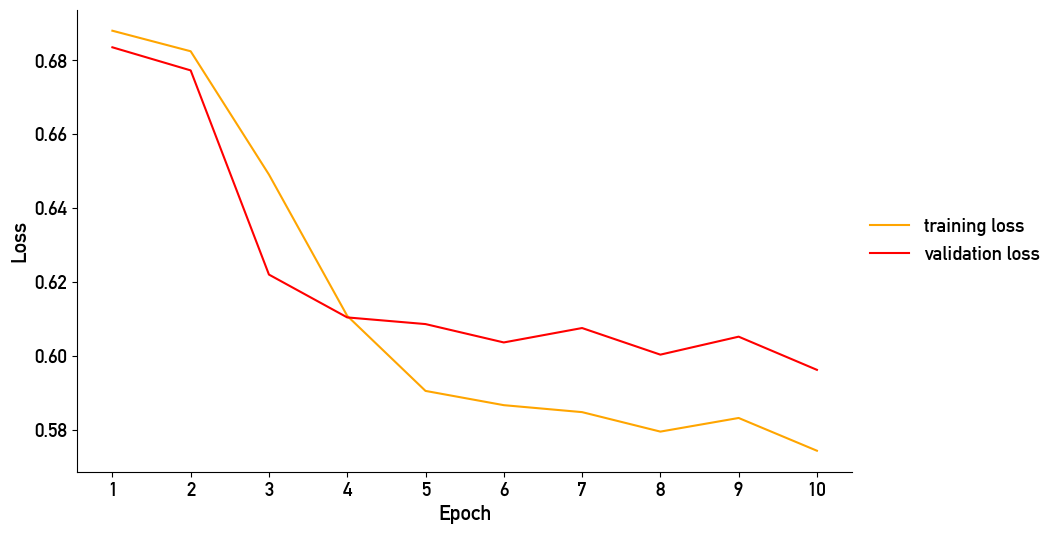

In [17]:
loss_path = os.path.join(vector_path, "model_outputs", "selection", "losses")
visualize_losses([model_name], loss_path)

### Accuracy metrics after training

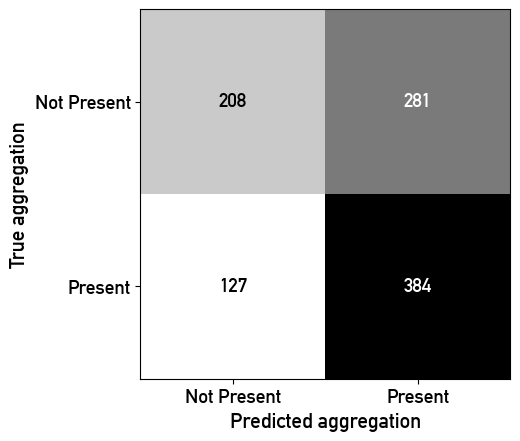

Accuracy: 0.592
Precision: 0.577
Recall: 0.751
F1 Score: 0.653


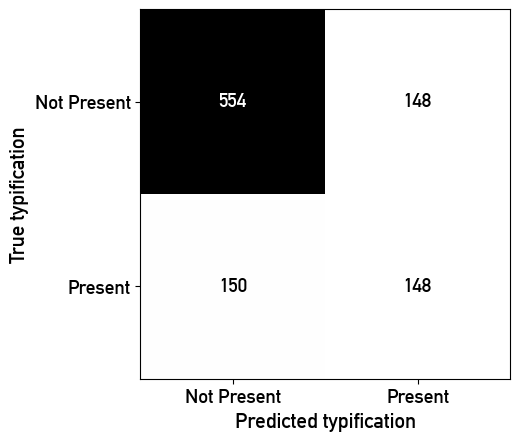

Accuracy: 0.702
Precision: 0.500
Recall: 0.497
F1 Score: 0.498


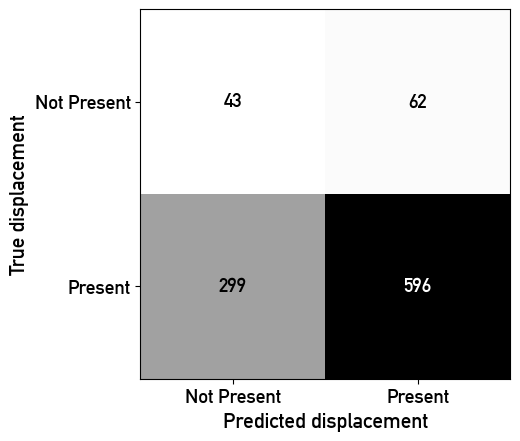

Accuracy: 0.639
Precision: 0.906
Recall: 0.666
F1 Score: 0.768


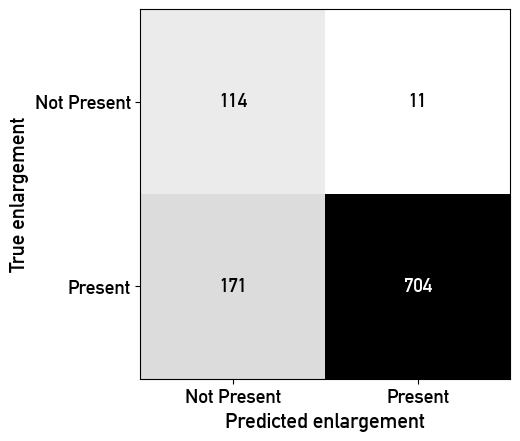

Accuracy: 0.818
Precision: 0.985
Recall: 0.805
F1 Score: 0.886


In [18]:
# switch to evaluation mode
model.eval()

# storing the predictions and true labels from every batch for every operator
true_operators_all = {}
pred_operators_all = {}

for operator_name in selection_operators:
    true_operators_all[operator_name] = []
    pred_operators_all[operator_name] = []

# prediction evaluations should not be part of the computational graph, gradients should not be tracked
with torch.no_grad():
    for graph in test_loader:
        # operators applied to the focal building
        operators = graph.y
        
        # moving the features to device
        graph = graph.to(device)
        operators = operators.to(device)

        # prediction on the trained model results in logits, sigmoid needs to be applied to obtain probabilities
        pred_operators_logits = model(graph.x_dict, graph.edge_index_dict)
        pred_operators = torch.sigmoid(pred_operators_logits)
        pred_operators_labels = (pred_operators > 0.5).float()  # thresholding

        # storing true labels and predictions for every operator
        for i, operator_name in enumerate(selection_operators):
            # extracting true and predicted operator
            true_operator_batch = operators[:,i]
            pred_operator_batch = pred_operators_labels[:,i]

            # collect data for metrics calculation
            true_operators_all[operator_name].append(true_operator_batch.cpu())
            pred_operators_all[operator_name].append(pred_operator_batch.cpu())

metrics = {"operator": [], 
           "accuracy": [], 
           "precision": [], 
           "recall": [], 
           "f1_score": []}

for operator_name in selection_operators:
    # convert lists to tensors
    cur_true_operator = torch.cat(true_operators_all[operator_name])
    cur_pred_operator = torch.cat(pred_operators_all[operator_name])

    # calculate metrics of the current operator
    conf_matrix = confusion_matrix(cur_true_operator.numpy(), cur_pred_operator.numpy())
    accuracy = accuracy_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    precision = precision_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    recall = recall_score(cur_true_operator.numpy(), cur_pred_operator.numpy())
    f1 = f1_score(cur_true_operator.numpy(), cur_pred_operator.numpy())

    # store the metrics of the current operator
    metrics["operator"].append(operator_name)
    metrics["accuracy"].append(accuracy)
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1_score"].append(f1)

    # display the confusion matrix
    visualize_confusion_matrix(conf_matrix, operator=operator_name)
    
    # print metrics
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

# saving the accuracy metrics
model_name = get_model_name(model, ops="sel", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".csv"
metrics_path = os.path.join(vector_path, "model_outputs", "selection", "metrics", model_name)

# creating a DataFrame with loss values
metrics_df = pd.DataFrame(metrics)

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

### Saving the model

In [19]:
# save the trained model to disk
path_to_models = os.path.join(vector_path, "models", "selection")

model_name = get_model_name(model, ops="sel", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, batch_size=batch_size) + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name))